In [108]:
import sys
!{sys.executable} -m pip install statsbombpy
from statsbombpy import sb


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [109]:
comps = sb.competitions()
# comps[comps["competition_name"]=="Premier League"]
# comps.sort_values(by="season_name",ascending=False).head(10)
# comp_match_counts = {}
# for _, row in comps.sort_values(by="season_name",ascending=False).head(20).iterrows():
#     matches = sb.matches(row["competition_id"], row["season_id"])
#     comp_match_counts[f"{row['competition_name']} ({row['season_name']})"] = len(matches)
# comp_match_counts


In [110]:
comps[comps["competition_name"]=="Premier League"]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
64,2,27,England,Premier League,male,False,False,2015/2016,2024-06-12T07:43:56.243851,2021-06-13T16:17:31.694,None,2024-06-12T07:43:56.243851
65,2,44,England,Premier League,male,False,False,2003/2004,2024-03-08T14:49:13.195793,2021-06-13T16:17:31.694,None,2024-03-08T14:49:13.195793


In [111]:
print("Amount of Games: ",sb.matches(2,27).shape[0])
sb.matches(2,27).head()

Amount of Games:  380


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3754058,2016-01-02,16:00:00.000,England - Premier League,2015/2016,Leicester City,AFC Bournemouth,0,0,available,...,2021-06-12T16:17:31.694,20,Regular Season,King Power Stadium,Andre Marriner,Claudio Ranieri,Eddie Howe,1.1.0,2,2
1,3754245,2015-10-17,16:00:00.000,England - Premier League,2015/2016,West Bromwich Albion,Sunderland,1,0,available,...,2021-06-13T16:17:31.694,9,Regular Season,The Hawthorns,Martin Atkinson,Tony Pulis,Sam Allardyce,1.1.0,2,2
2,3754136,2015-12-19,18:30:00.000,England - Premier League,2015/2016,Newcastle United,Aston Villa,1,1,available,...,2021-06-13T16:17:31.694,17,Regular Season,St. James'' Park,Martin Atkinson,Steve McClaren,Rémi Garde,1.1.0,2,2
3,3754037,2016-04-30,16:00:00.000,England - Premier League,2015/2016,Everton,AFC Bournemouth,2,1,available,...,2021-06-12T16:17:31.694,36,Regular Season,Goodison Park,Neil Swarbrick,Roberto Martínez Montoliú,Eddie Howe,1.1.0,2,2
4,3754039,2016-02-13,16:00:00.000,England - Premier League,2015/2016,Crystal Palace,Watford,1,2,available,...,2021-06-12T16:17:31.694,26,Regular Season,Selhurst Park,Robert Madley,Alan Pardew,Enrique Sánchez Flores,1.1.0,2,2


In [112]:
ordered_events =  sb.events(3754058).sort_values(by=["period","timestamp"],ascending=[True,True])

In [113]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import numpy as np
import pandas as pd

In [114]:
ordered_events = ordered_events[~ordered_events["location"].isna()]

In [115]:
ordered_events.columns


Index(['ball_receipt_outcome', 'ball_recovery_recovery_failure',
       'carry_end_location', 'clearance_aerial_won', 'clearance_body_part',
       'clearance_head', 'clearance_left_foot', 'clearance_right_foot',
       'counterpress', 'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun',
       'duel_outcome', 'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_penalty', 'foul_committed_type', 'foul_won_advantage',
       'foul_won_defensive', 'foul_won_penalty', 'goalkeeper_body_part',
       'goalkeeper_end_location', 'goalkeeper_outcome', 'goalkeeper_position',
       'goalkeeper_punched_out', 'goalkeeper_technique', 'goalkeeper_type',
       'id', 'index', 'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_deflecte

In [116]:
ordered_events["type"].value_counts() 

type
Pass              1002
Ball Receipt*      924
Carry              742
Pressure           363
Ball Recovery      102
Duel                83
Clearance           59
Block               42
Goal Keeper         35
Miscontrol          34
Dribble             31
Dispossessed        29
Shot                27
Interception        25
Dribbled Past       19
Foul Committed      19
Foul Won            18
Shield               1
Name: count, dtype: int64

In [117]:
ordered_events = ordered_events[ordered_events["type"].isin(["Pass","Carry","Ball Recovery","Duel","Clearance","Miscontrol","Dribble","Shot","Interception","Foul Committed"])]

In [122]:
# pitch = Pitch(positional=True, axis=True)
# fig, ax = plt.subplots(figsize = (10,6))
# pitch.draw(ax=ax)

# event = "Clearance"
# team = "AFC Bournemouth"
# period = 1
# passes = ordered_events[(ordered_events["type"]==event)&(ordered_events["team"]==team)&(ordered_events["period"]==period)]
# for i in range(passes.shape[0]):
#     row = passes.iloc[i]
#     if row["pass_outcome"] not in {"Incomplete","Out","Injury Clearance","Pass Offside","Unknown"}:
#         color = 'g'
#     else:
#         color = 'r'
#     if event == "Pass":
#         plt.arrow(int(row["location"][0]),int(row["location"][1]),int(row["pass_end_location"][0]-row["location"][0]),int(row["pass_end_location"][1]-row["location"][1]),color=color,alpha=.5,width=.1)
#     elif event == "Duel":
#         plt.plot(int(row["location"][0]),int(row["location"][1]),'ro')
#     elif event == "Carry":
#         plt.arrow(int(row["location"][0]),int(row["location"][1]),int(row["carry_end_location"][0]-row["location"][0]),int(row["carry_end_location"][1]-row["location"][1]),color=color,alpha=.5,width=.1)
#     else:
#         plt.plot(int(row["location"][0]),int(row["location"][1]),'ro')

# plt.title(f"AFC Bournemouth Possession")
# plt.show()


In [119]:
# Split events by team
away_team = ordered_events[ordered_events["team"] == "Leicester City"].copy()
home_team = ordered_events[ordered_events["team"] == "AFC Bournemouth"].copy()

# Function to flip coordinates
def flip_coordinates(coords):
    if isinstance(coords, list):
        return [120 - coords[0], 80 - coords[1]]
    return coords

# Flip all coordinate columns for away team
coordinate_columns = ["location", "pass_end_location", "carry_end_location", "shot_end_location"]
for column in coordinate_columns:
    away_team[column] = away_team[column].apply(flip_coordinates)

# Combine home and away events
ordered_events = pd.concat([home_team, away_team])


In [120]:
ordered_events.loc[ordered_events["possession"] == 22, [
    "type", "location", "pass_end_location", "pass_outcome",
    "carry_end_location",  "duel_type", "duel_outcome","team","dribble_outcome","possession_team"
]].head(50)

,type,location,pass_end_location,pass_outcome,carry_end_location,duel_type,duel_outcome,team,dribble_outcome,possession_team
180,Pass,"[36.8, 22.8]","[46.2, 28.8]",NaN,NaN,NaN,NaN,AFC Bournemouth,NaN,Leicester City
181,Pass,"[46.2, 29.0]","[66.8, 25.6]",Incomplete,NaN,NaN,NaN,AFC Bournemouth,NaN,Leicester City
175,Pass,"[58.6, 0.0]","[54.7, 11.200000000000003]",NaN,NaN,NaN,NaN,Leicester City,NaN,Leicester City
2060,Carry,"[54.7, 11.200000000000003]",NaN,NaN,"[54.099999999999994, 11.200000000000003]",NaN,NaN,Leicester City,NaN,Leicester City
176,Pass,"[54.099999999999994, 11.200000000000003]","[50.0, 4.799999999999997]",NaN,NaN,NaN,NaN,Leicester City,NaN,Leicester City
177,Pass,"[50.0, 4.799999999999997]","[56.4, 7.799999999999997]",NaN,NaN,NaN,NaN,Leicester City,NaN,Leicester City
2061,Carry,"[56.4, 7.799999999999997]",NaN,NaN,"[64.3, 8.599999999999994]",NaN,NaN,Leicester City,NaN,Leicester City
178,Pass,"[64.3, 8.599999999999994]","[81.7, 19.5]",NaN,NaN,NaN,NaN,Leicester City,NaN,Leicester City
2062,Carry,"[81.7, 19.5]",NaN,NaN,"[76.9, 9.099999999999994]",NaN,NaN,Leicester City,NaN,Leicester City
179,Pass,"[76.9, 9.099999999999994]","[36.7, 22.700000000000003]",Incomplete,NaN,NaN,NaN,Leicester City,NaN,Leicester City


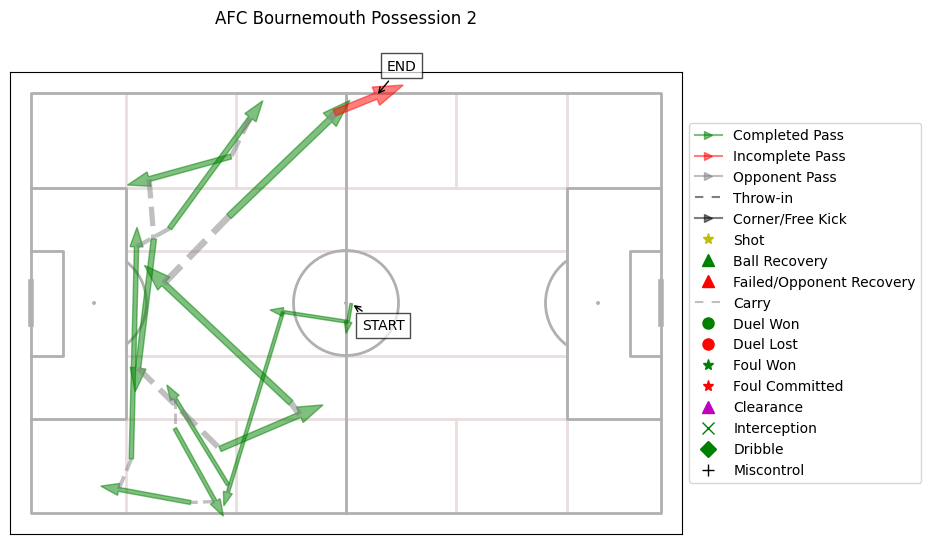

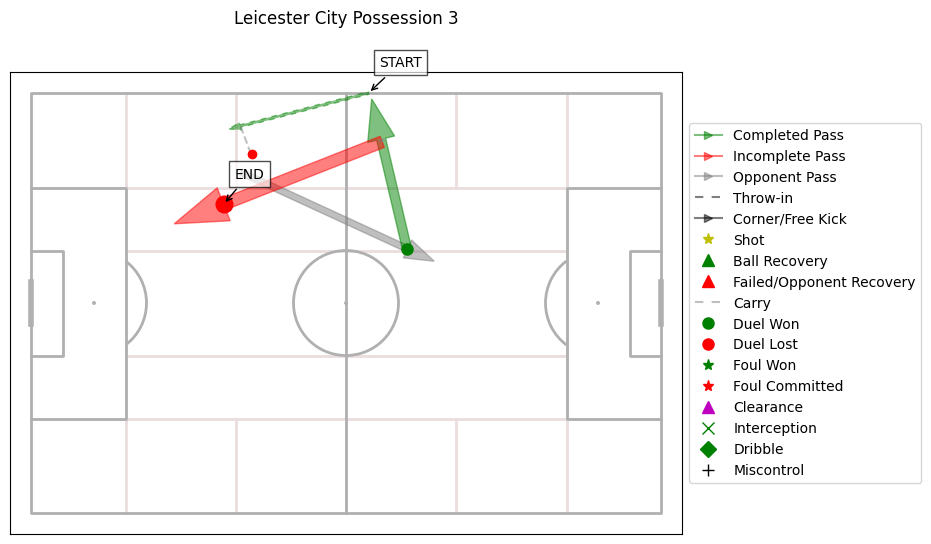

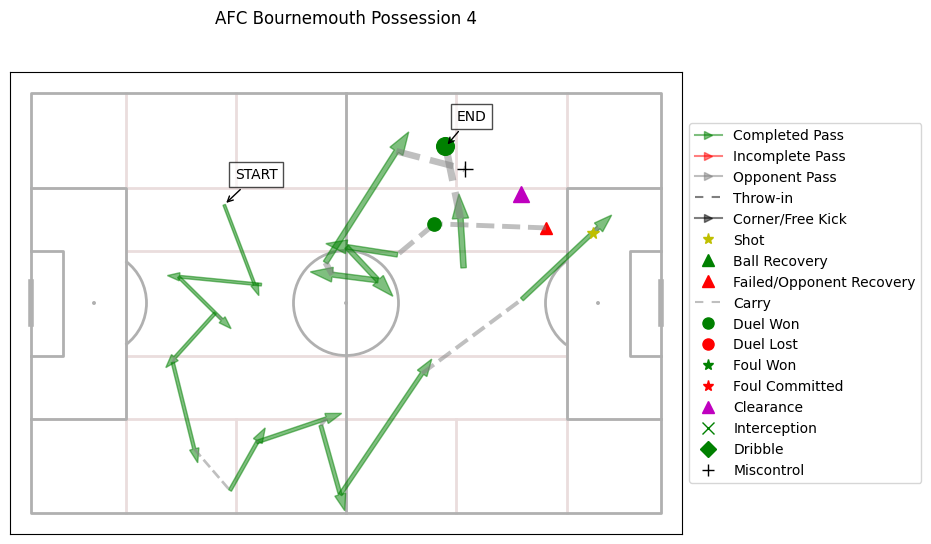

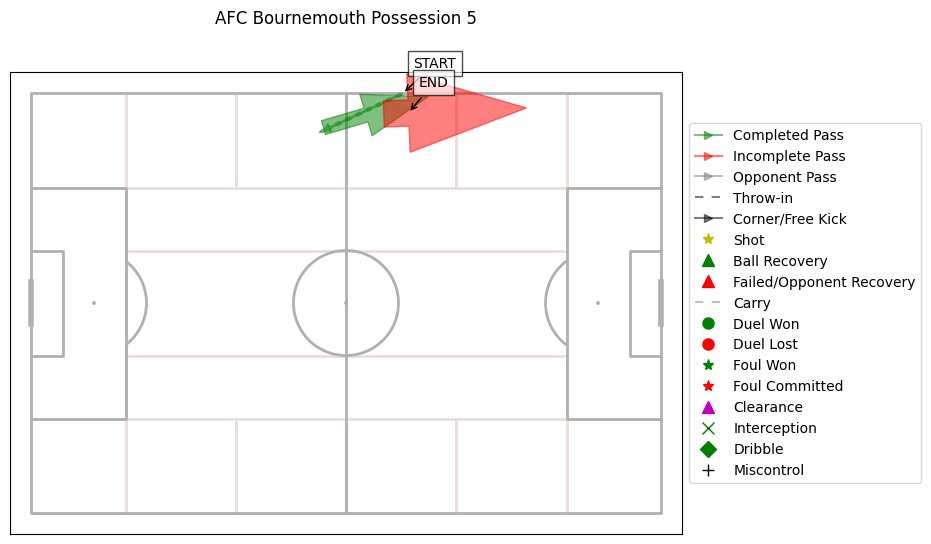

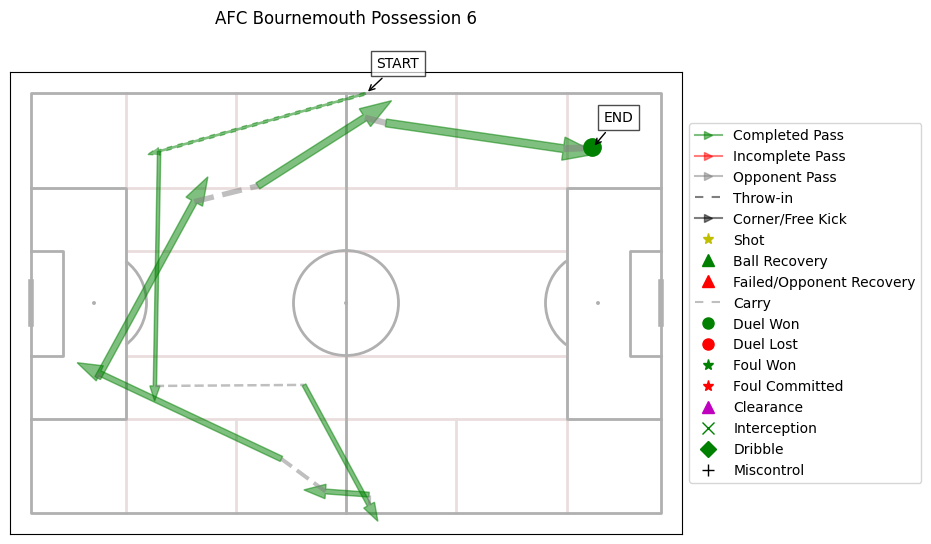

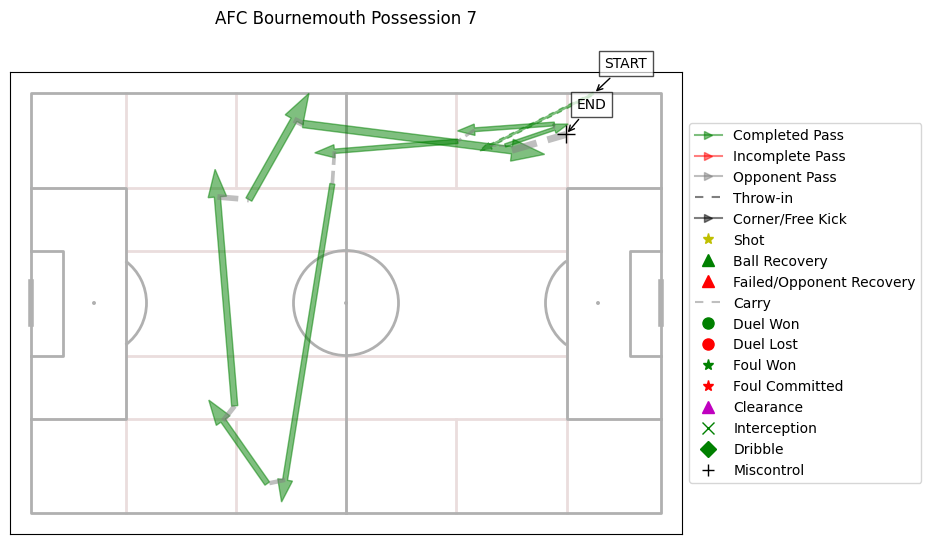

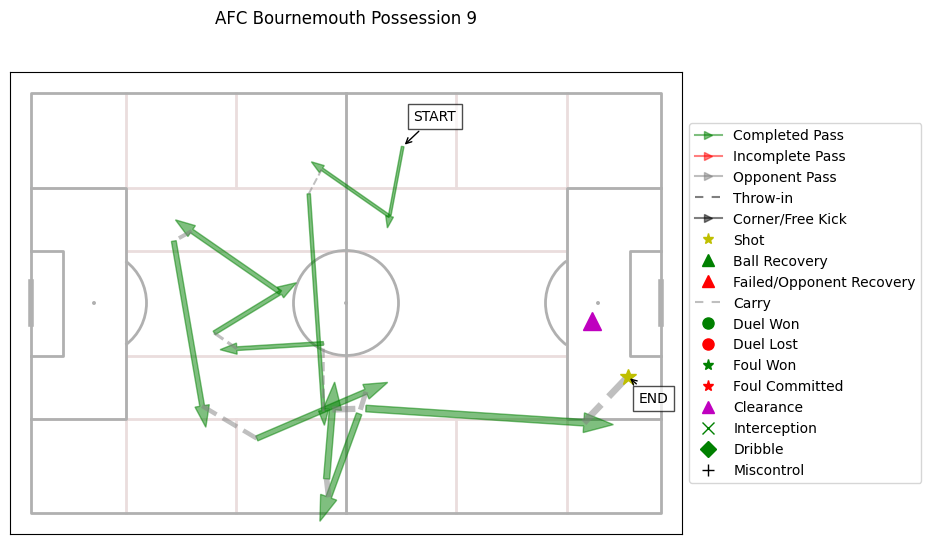

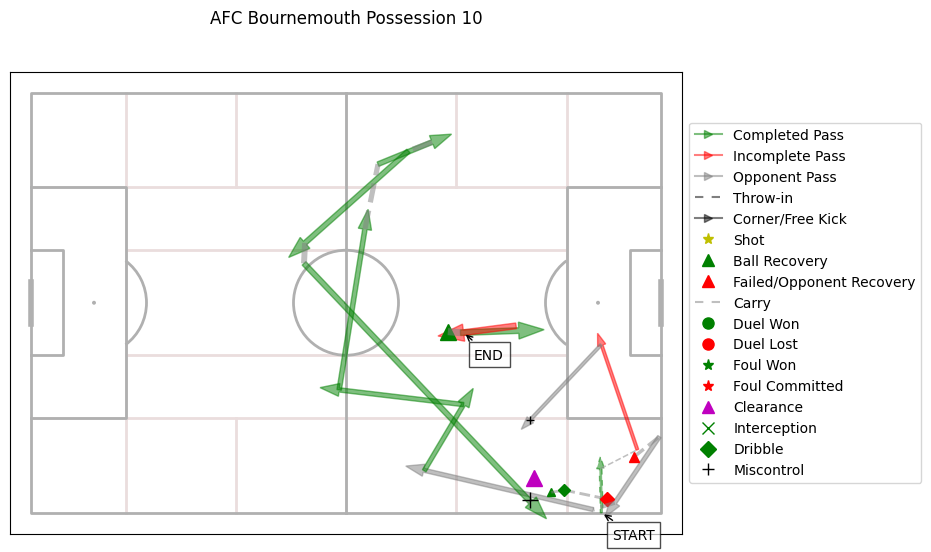

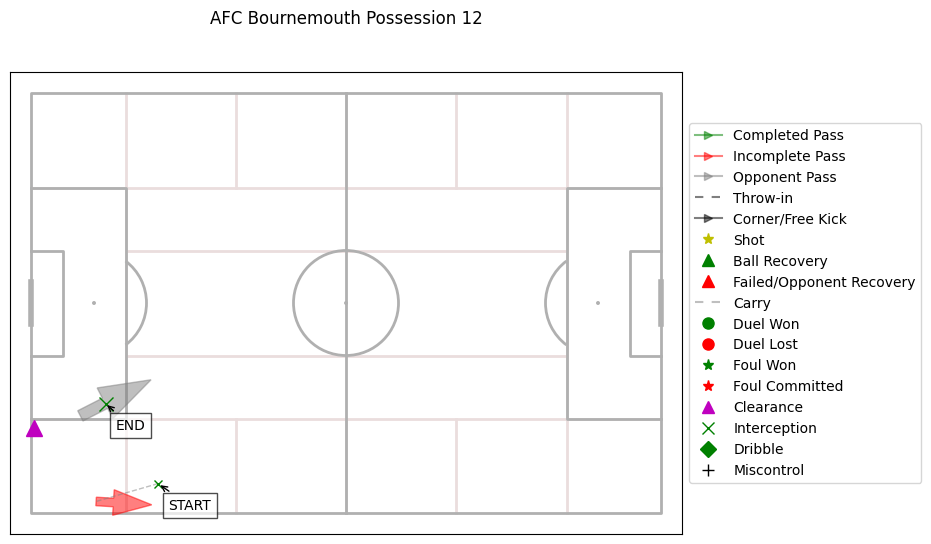

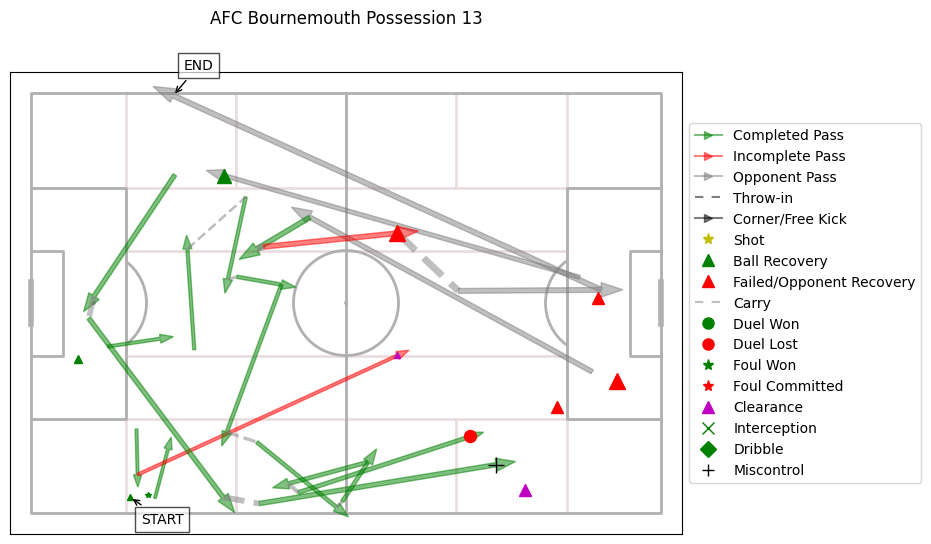

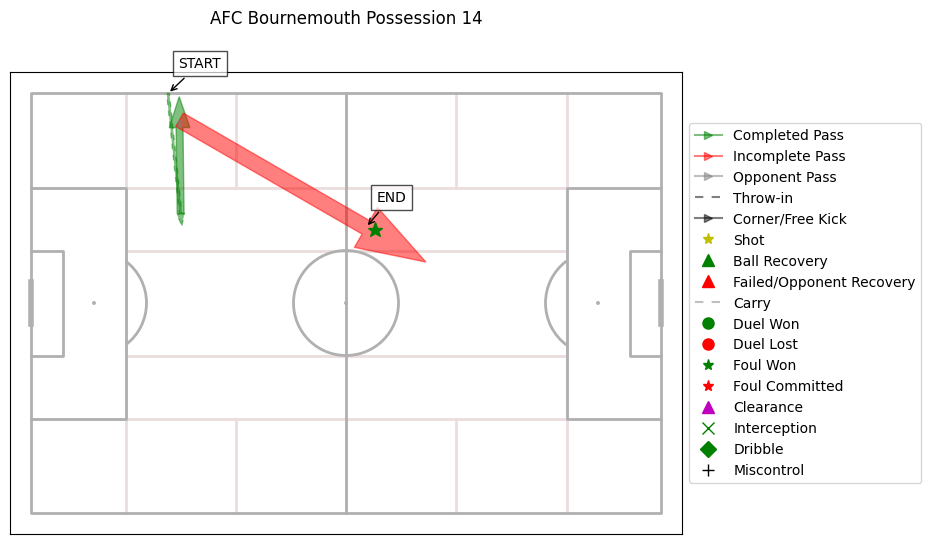

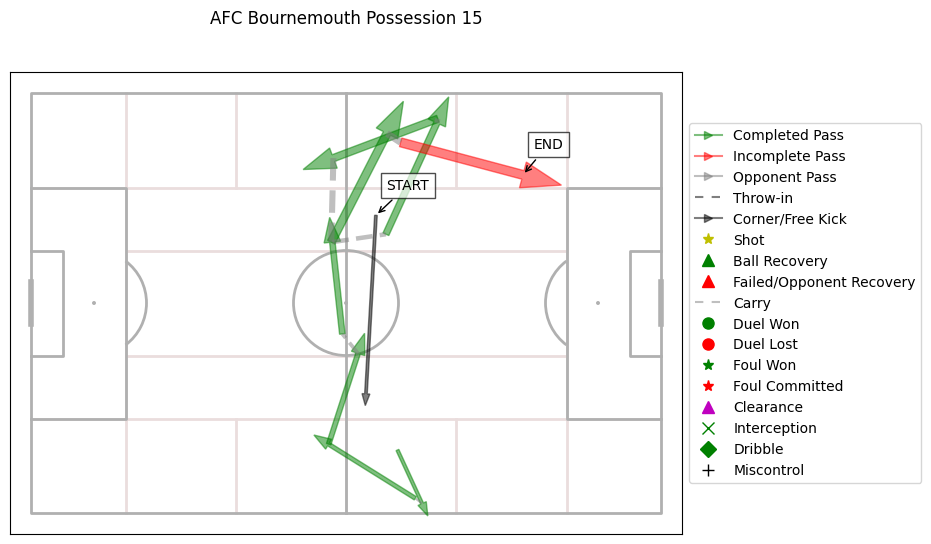

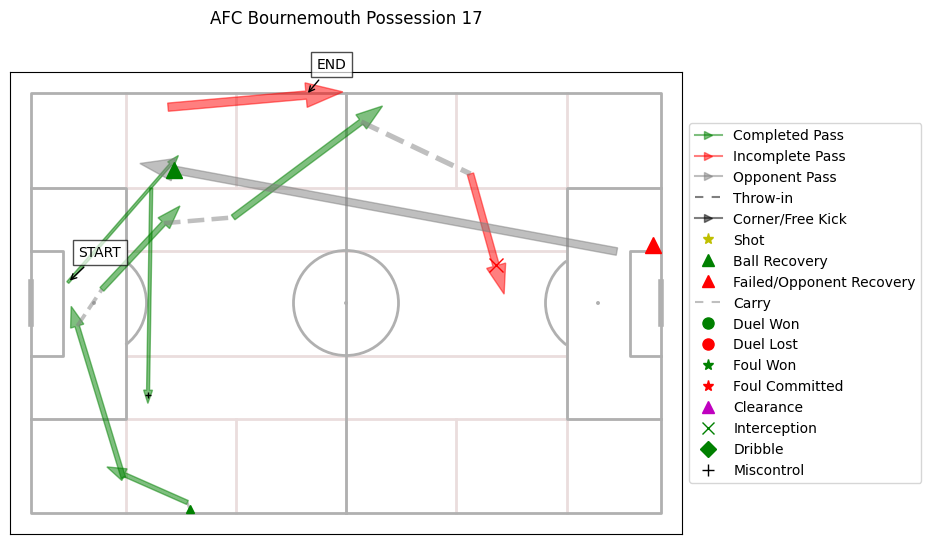

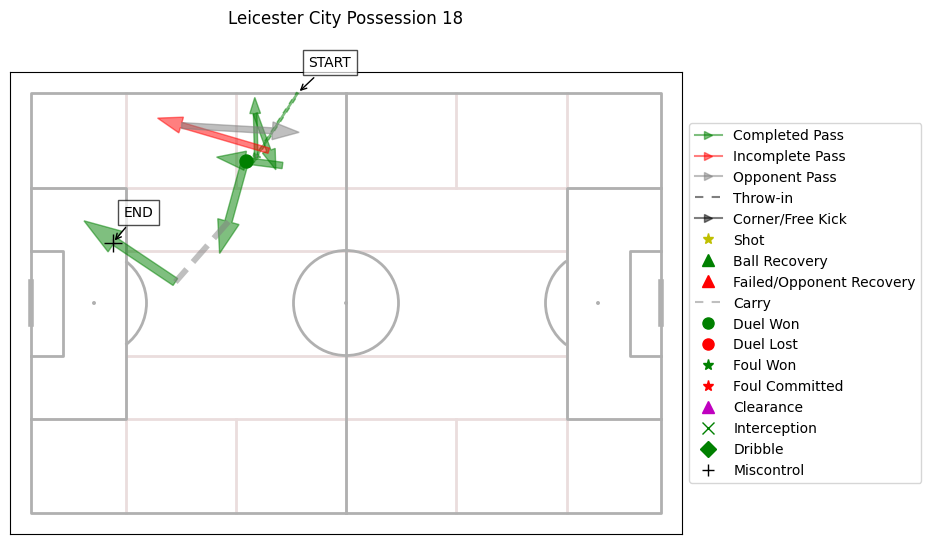

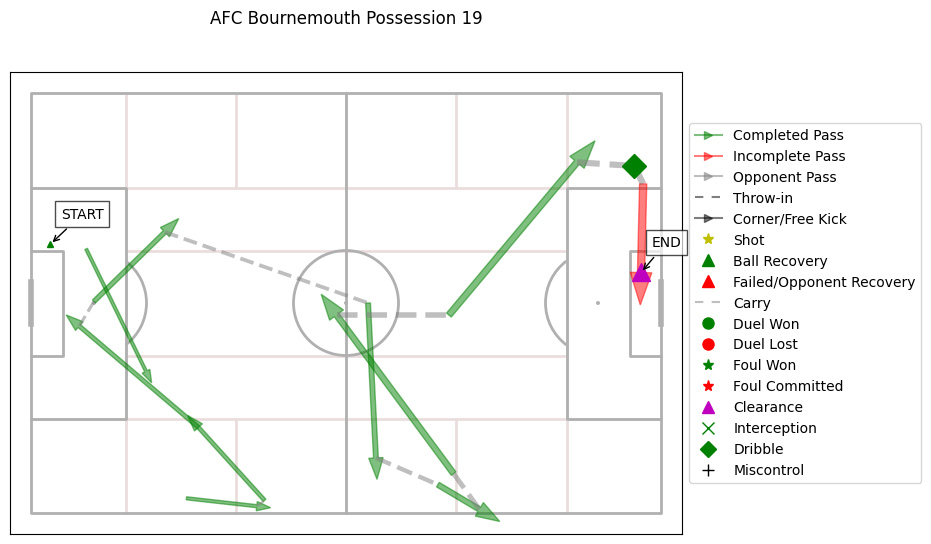

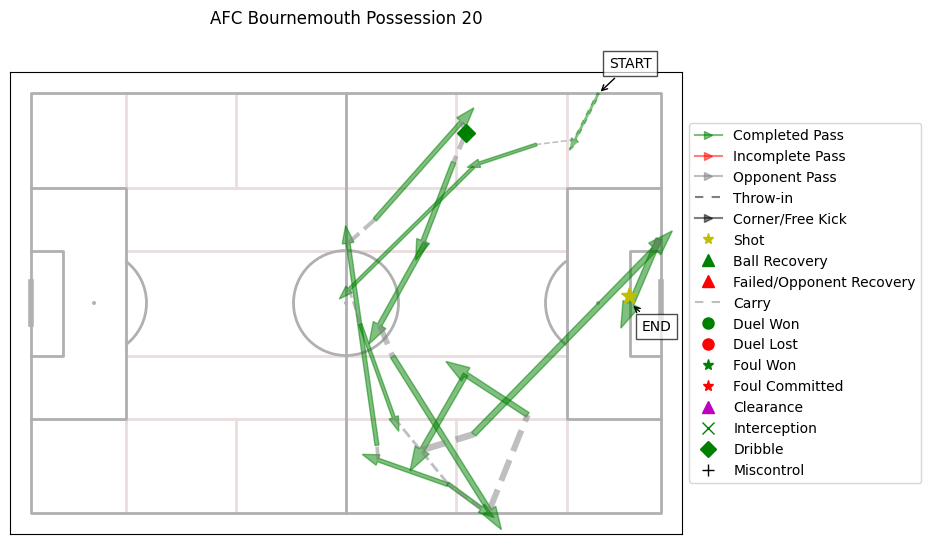

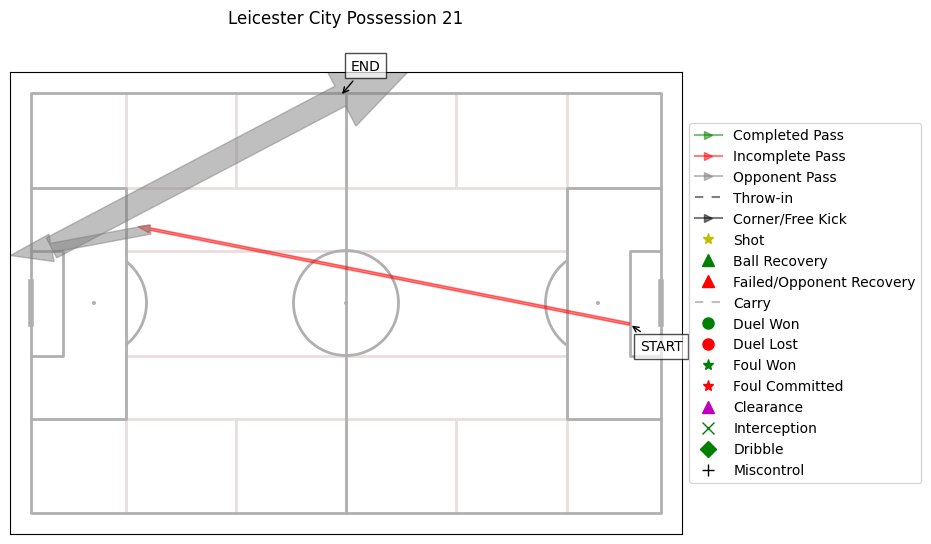

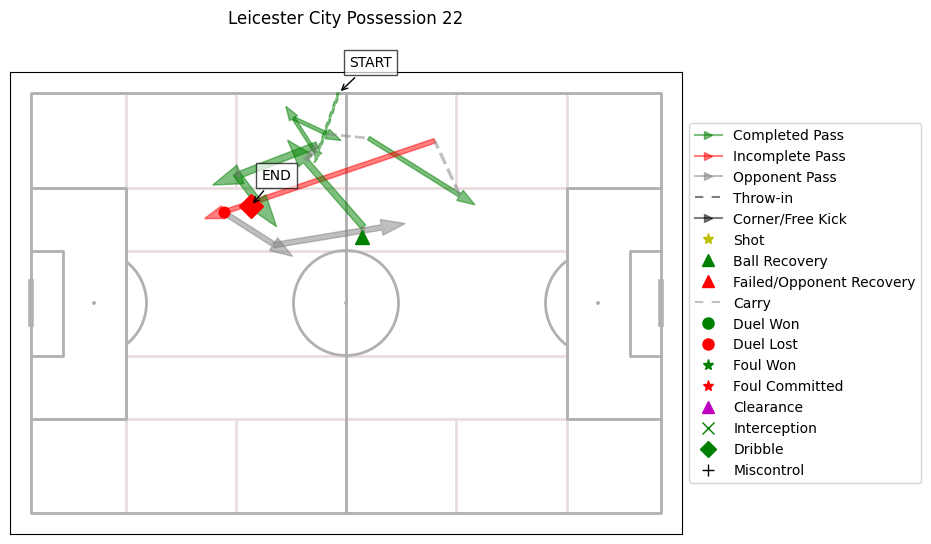

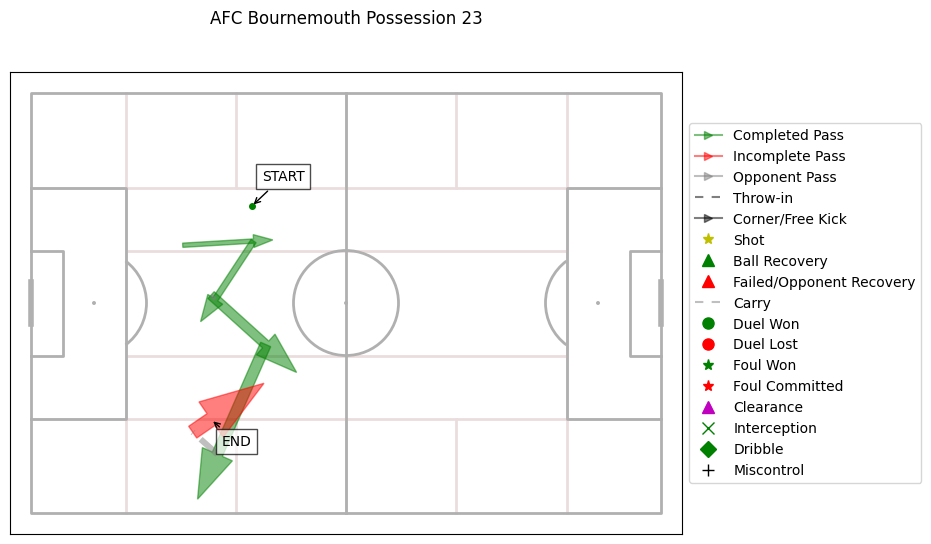

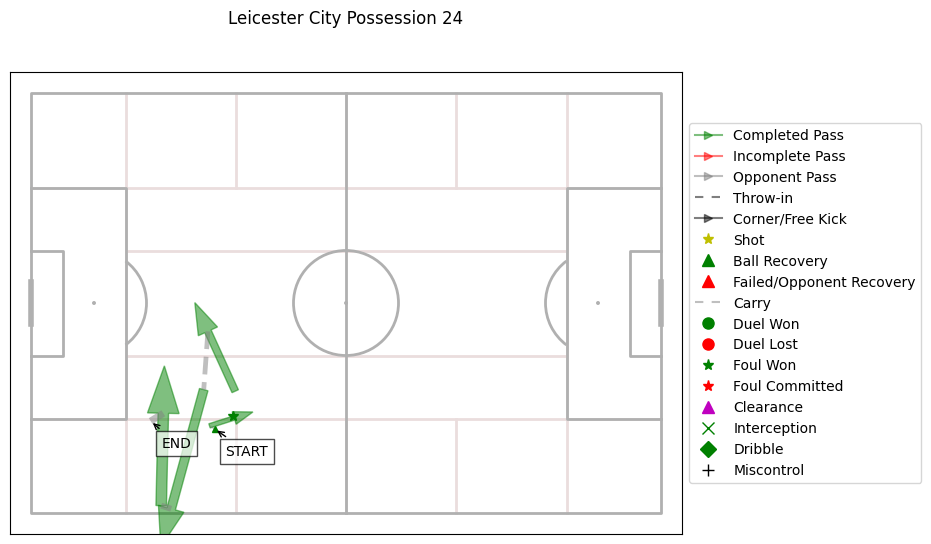

In [123]:
for possession in ordered_events["possession"].unique()[:20]:
    # Get events for this possession
    possession_events = ordered_events[ordered_events["possession"] == possession]
    team = possession_events["possession_team"].unique()[0]
    
    # Create pitch visualization
    pitch = Pitch(positional=True, axis=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    pitch.draw(ax=ax)
    
    # Sort events by timestamp and calculate width increment
    possession_events = possession_events.sort_values(by=["timestamp"], ascending=True)
    min_width = .5
    max_width = 5
    width_increment = (max_width - min_width) / len(possession_events)
    
    # Get first and last event locations
    first_event = possession_events.iloc[0]
    last_event = possession_events.iloc[-1]
    start_x, start_y = first_event["location"]
    end_x, end_y = last_event["location"]
    
    # Plot each event
    j=0
    for i, event in possession_events.iterrows():
        x, y = event["location"]
        event_team = event["team"]
        width = min_width + j * width_increment
        marker_size = 4 + j * 2

        if event["type"] == "Pass" and "pass_end_location" in event and isinstance(event["pass_end_location"], list):
            end_x, end_y = event["pass_end_location"]
            incomplete_outcomes = {"Incomplete", "Out", "Injury Clearance", "Pass Offside", "Unknown"}
            color = 'g' if event.get("pass_outcome") not in incomplete_outcomes else 'r'
            linestyle = (0, (4, 4, 4, 4)) if event["pass_type"] == "Throw-in" else '-'
            
            if event["pass_type"] in ["Corner", "Free Kick"]:
                color = 'k'
            if event_team != team:
                color = 'gray'
                
            plt.arrow(x, y, end_x-x, end_y-y, color=color, alpha=0.5, width=width, ls=linestyle)
            
        elif event["type"] == "Shot":
            plt.plot(x, y, 'y*', markersize=marker_size)
            
        elif event["type"] == "Ball Recovery":
            failed_recovery = (event["ball_recovery_recovery_failure"] == True and event_team == team)
            opponent_recovery = (event["ball_recovery_recovery_failure"] != True and event_team != team)
            color = 'r' if failed_recovery or opponent_recovery else 'g'
            plt.plot(x, y, f'{color}^', markersize=marker_size)
            
        elif event["type"] == "Carry" and "carry_end_location" in event and isinstance(event["carry_end_location"], list):
            end_x, end_y = event["carry_end_location"]
            plt.plot([x, end_x], [y, end_y], color='gray', alpha=0.5, linewidth=1+j, linestyle='--')
            
        elif event["type"] == "Duel":
            lost = "Lost" in event["duel_type"] or "Lost" in event["duel_outcome"]
            if event_team != team:
                lost = not lost  # Flip the outcome for opponent team
            color = 'r' if lost else 'g'
            plt.plot(x, y, f'{color}o', markersize=marker_size)
            
        elif event["type"] == "Foul Committed":
            color = 'g' if event_team != team else 'r'
            plt.plot(x, y, f'{color}*', markersize=marker_size)
            
        elif event["type"] == "Clearance":
            plt.plot(x, y, 'm^', markersize=marker_size)

        elif event["type"] == "Interception":
            interception_outcome = not ("Lost" in event.get('interception_outcome'))
            if interception_outcome & (event_team == team):
                color = 'g'
            elif interception_outcome & (event_team != team):
                color = 'r'
            elif not interception_outcome & (event_team != team):
                color = 'g'
            else:
                color = 'r'
            plt.plot(x, y, f'{color}x', markersize=marker_size)
        elif event["type"] == "Dribble":
            dribble_outcome = "Complete"==event.get('dribble_outcome')
            if dribble_outcome & (event_team == team):
                color = 'g'         
            else:
                color = 'r'
            plt.plot(x, y, f'{color}D', markersize=marker_size)
        elif event["type"] == "Miscontrol":
            plt.plot(x, y, 'k+', markersize=marker_size)
            
        j+=width_increment
    
    # Add start and end text annotations
    offset = 5
    start_offset = offset if start_y > 40 else -offset
    end_offset = offset if end_y > 40 else -offset
    plt.annotate('START', xy=(start_x, start_y), xytext=(start_x+2, start_y+start_offset),
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
                arrowprops=dict(arrowstyle='->'))
    plt.annotate('END', xy=(end_x, end_y), xytext=(end_x+2, end_y+end_offset),
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
                arrowprops=dict(arrowstyle='->'))
    
    # Add title after annotations to ensure it's on top
    plt.title(f"{team} Possession {possession}", pad=35)  # Added padding to avoid overlap
            
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='g', marker='>', linestyle='-', label='Completed Pass', alpha=0.5),
        plt.Line2D([0], [0], color='r', marker='>', linestyle='-', label='Incomplete Pass', alpha=0.5),
        plt.Line2D([0], [0], color='gray', marker='>', linestyle='-', label='Opponent Pass', alpha=0.5),
        plt.Line2D([0], [0], color='k', linestyle=(0, (4, 4, 4, 4)), label='Throw-in', alpha=0.5),
        plt.Line2D([0], [0], color='k', marker='>', linestyle='-', label='Corner/Free Kick', alpha=0.5),
        plt.Line2D([0], [0], color='y', marker='*', linestyle='none', label='Shot', markersize=8),
        plt.Line2D([0], [0], color='g', marker='^', linestyle='none', label='Ball Recovery', markersize=8),
        plt.Line2D([0], [0], color='r', marker='^', linestyle='none', label='Failed/Opponent Recovery', markersize=8),
        plt.Line2D([0], [0], color='gray',linestyle=(0, (4, 4, 4, 4)), label='Carry', alpha=0.5),
        plt.Line2D([0], [0], color='g', marker='o', linestyle='none', label='Duel Won', markersize=8),
        plt.Line2D([0], [0], color='r', marker='o', linestyle='none', label='Duel Lost', markersize=8),
        plt.Line2D([0], [0], color='g', marker='*', linestyle='none', label='Foul Won', markersize=8),
        plt.Line2D([0], [0], color='r', marker='*', linestyle='none', label='Foul Committed', markersize=8),
        plt.Line2D([0], [0], color='m', marker='^', linestyle='none', label='Clearance', markersize=8),
        plt.Line2D([0], [0], color='g', marker='x', linestyle='none', label='Interception', markersize=8),
        plt.Line2D([0], [0], color='g', marker='D', linestyle='none', label='Dribble', markersize=8),
        plt.Line2D([0], [0], color='k', marker='+', linestyle='none', label='Miscontrol', markersize=8),
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
